# Considering Outlier Detection

In [1]:
import numpy as np

np.random.seed(1)
normal = np.random.normal(loc=0.0, scale=1.0, size=1000)
mean = np.mean(normal)
median = np.median(normal)
variance = np.var(normal)

print(f"Mean: {mean:.3f} Median: {median:.3f} ",
      f"Variance: {variance:.3f}")

Mean: 0.039 Median: 0.041  Variance: 0.962


In [2]:
from scipy.stats import pearsonr

outlying = normal.copy()
outlying[0] = 50.0

mean = np.mean(outlying)
median = np.median(outlying)
variance = np.var(outlying)

print(f"Mean: {mean:.3f} Median: {median:.3f} ",
      f"Variance: {variance:.3f}")

corr_coef, p_value = pearsonr(normal, outlying)
print(f"Pearson's correlation: {corr_coef:.3f} ",
      f"p-value: {p_value:.3f}")

Mean: 0.087 Median: 0.041  Variance: 3.454
Pearson's correlation: 0.570  p-value: 0.000


# Examining a Simple Univariate Method

In [3]:
import pandas as pd
from sklearn.datasets import load_diabetes

def load_diabetes_data():
    diabetes = load_diabetes()
    X = pd.DataFrame(diabetes.data, 
                     columns=diabetes.feature_names)
    y = pd.DataFrame(diabetes.target, columns=['target'])
    return X, y

X, y = load_diabetes_data()

Samples total	442<BR>
Dimensionality	10<BR>
Features	real, -.2 < x < .2<BR>
Targets	integer 25 - 346<BR>

In [4]:
pd.options.display.float_format = '{:.2f}'.format
X.describe()

age    sex    bmi     bp     s1     s2     s3     s4     s5     s6
count 442.00 442.00 442.00 442.00 442.00 442.00 442.00 442.00 442.00 442.00
mean   -0.00   0.00  -0.00  -0.00  -0.00   0.00  -0.00  -0.00   0.00   0.00
std     0.05   0.05   0.05   0.05   0.05   0.05   0.05   0.05   0.05   0.05
min    -0.11  -0.04  -0.09  -0.11  -0.13  -0.12  -0.10  -0.08  -0.13  -0.14
25%    -0.04  -0.04  -0.03  -0.04  -0.03  -0.03  -0.04  -0.04  -0.03  -0.03
50%     0.01  -0.04  -0.01  -0.01  -0.00  -0.00  -0.01  -0.00  -0.00  -0.00
75%     0.04   0.05   0.03   0.04   0.03   0.03   0.03   0.03   0.03   0.03
max     0.11   0.05   0.17   0.13   0.15   0.20   0.18   0.19   0.13   0.14

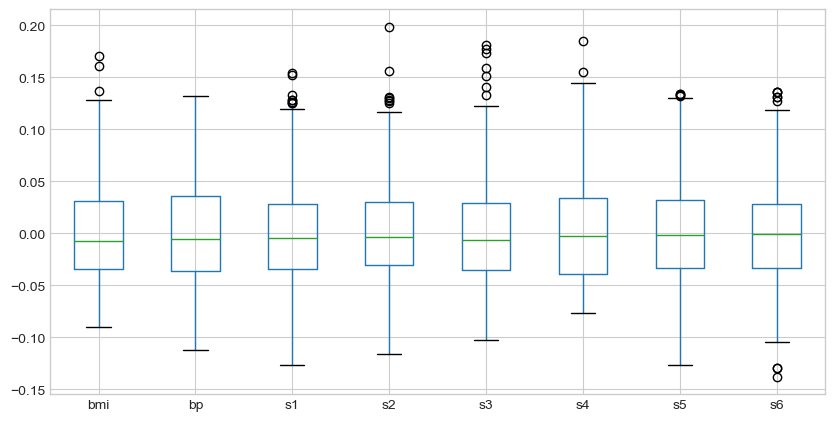

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")

fig, axes = plt.subplots(nrows=1, ncols=1, 
                         figsize=(10, 5))

features = ["bmi", "bp", "s1", "s2", "s3", "s4", "s5" ,"s6"]
X[features].boxplot(ax=axes);

## Leveraging on the Gaussian distribution

In [6]:
from sklearn.preprocessing import StandardScaler

Xs = StandardScaler().fit_transform(X[features])
# .any(1) method will avoid duplicating 
X[features][(np.abs(Xs)>3).any(1)].index

Int64Index([58, 123, 216, 230, 256, 260, 261, 269, 322, 336, 367, 441], dtype='int64')

## Remediating outliers

In [7]:
mean = X[features].mean()
std = X[features].std()

# Exclude the rows where any value is over 3 standard deviations from the mean
all_valid_mask = (np.abs(X[features] - mean) <= 
                  (3 * std)).all(axis=1)
listwise_del = X[all_valid_mask]

print(listwise_del.shape)

(430, 10)


In [8]:
from scipy.stats.mstats import winsorize

winsorized = X.copy()
winsorized[features] = winsorized[features].apply(
    lambda x: winsorize(x, limits=(0.05, 0.05)))

In [9]:
from sklearn.preprocessing import RobustScaler

robust_rescale = RobustScaler().fit_transform(
    X[features])

# Developing a Multivariate Approach

## Using principal component analysis

variance by the first two components: 55.2%
variance by the last two components: 0.9%


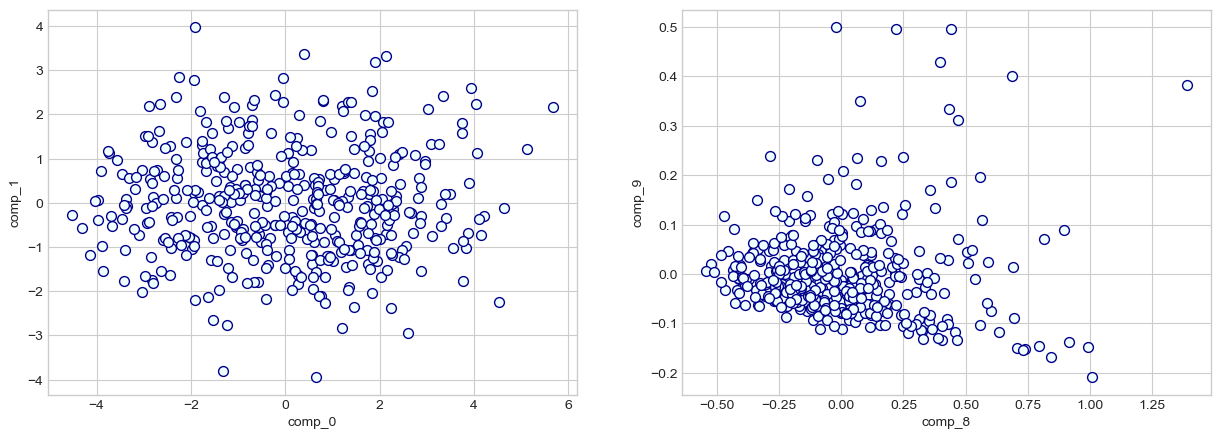

In [10]:
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from pandas.plotting import scatter_matrix
import pandas as pd
import matplotlib.pyplot as plt

pca = PCA()
pca_mat = pca.fit_transform(scale(X))

first_comps = sum(pca.explained_variance_ratio_[:2] * 100)
last_comps = sum(pca.explained_variance_ratio_[-2:] * 100)

print(f"variance by the first two components: "
      f"{first_comps:.1f}%")
print(f"variance by the last two components: "
      f"{last_comps:.1f}%")

df_pca = pd.DataFrame(
    pca_mat, columns=[f"comp_{j}" for j in range(10)])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
first_two = df_pca.plot.scatter(
    x="comp_0", y="comp_1", s=50, grid=True,
    c="Azure", edgecolors="DarkBlue", ax=axes[0])
last_two = df_pca.plot.scatter(
    x="comp_8", y="comp_9", s=50, grid=True,
    c="Azure", edgecolors="DarkBlue", ax=axes[1])

plt.show()

In [11]:
outlying = (pca_mat[:,-1] > 0.3) | (pca_mat[:,-2] > 1.0)
df_pca[outlying].index

Int64Index([23, 58, 110, 169, 254, 322, 323, 353, 371, 394], dtype='int64')

## Using cluster analysis

In [12]:
from sklearn.cluster import DBSCAN
DB = DBSCAN(eps=2.5, min_samples=25)
DB.fit(pca_mat)

from collections import Counter
print(Counter(DB.labels_))

df_pca[DB.labels_==-1].index

Counter({0: 414, -1: 28})


Int64Index([ 15,  23,  29,  35,  78, 117, 123, 141, 161, 169, 230, 248, 251,
            261, 276, 321, 322, 323, 336, 349, 352, 353, 367, 376, 394, 405,
            422, 441],
           dtype='int64')

## Automating outliers detection with Isolation Forests

In [13]:
from sklearn.ensemble import IsolationForest
auto_detection = IsolationForest(max_samples=50, 
                                 contamination=0.05,
                                 random_state=0)
auto_detection.fit(pca_mat)

iforest = auto_detection.predict(pca_mat)
df_pca[iforest==-1].index

Int64Index([ 10,  11,  15,  23,  32,  58, 110, 123, 141, 202, 230, 260, 261,
            269, 286, 321, 322, 323, 352, 353, 382, 394, 441],
           dtype='int64')